In [43]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

In [44]:
# Upload and Load Dataset
from google.colab import files
uploaded = files.upload()
df = pd.read_csv("weatherAUS.csv")
print("Initial shape:", df.shape)
df.head()

Initial shape: (145460, 23)


,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [45]:
# Fill Missing Values
for col in df.columns:
    if df[col].dtype == 'object':
        df[col].fillna(df[col].mode()[0], inplace=True)
    else:
        if df[col].skew() > 1:
            df[col].fillna(df[col].median(), inplace=True)
        else:
            df[col].fillna(df[col].mean(), inplace=True)
print("Missing values after filling:", df.isnull().sum().sum())

Missing values after filling: 0


In [46]:
# Encode Categorical Variables
cat_cols = df.select_dtypes(include='object').columns
le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col].astype(str))

In [47]:
# Drop rows with missing target (if any remain)
df.dropna(subset=['RainTomorrow'], inplace=True)

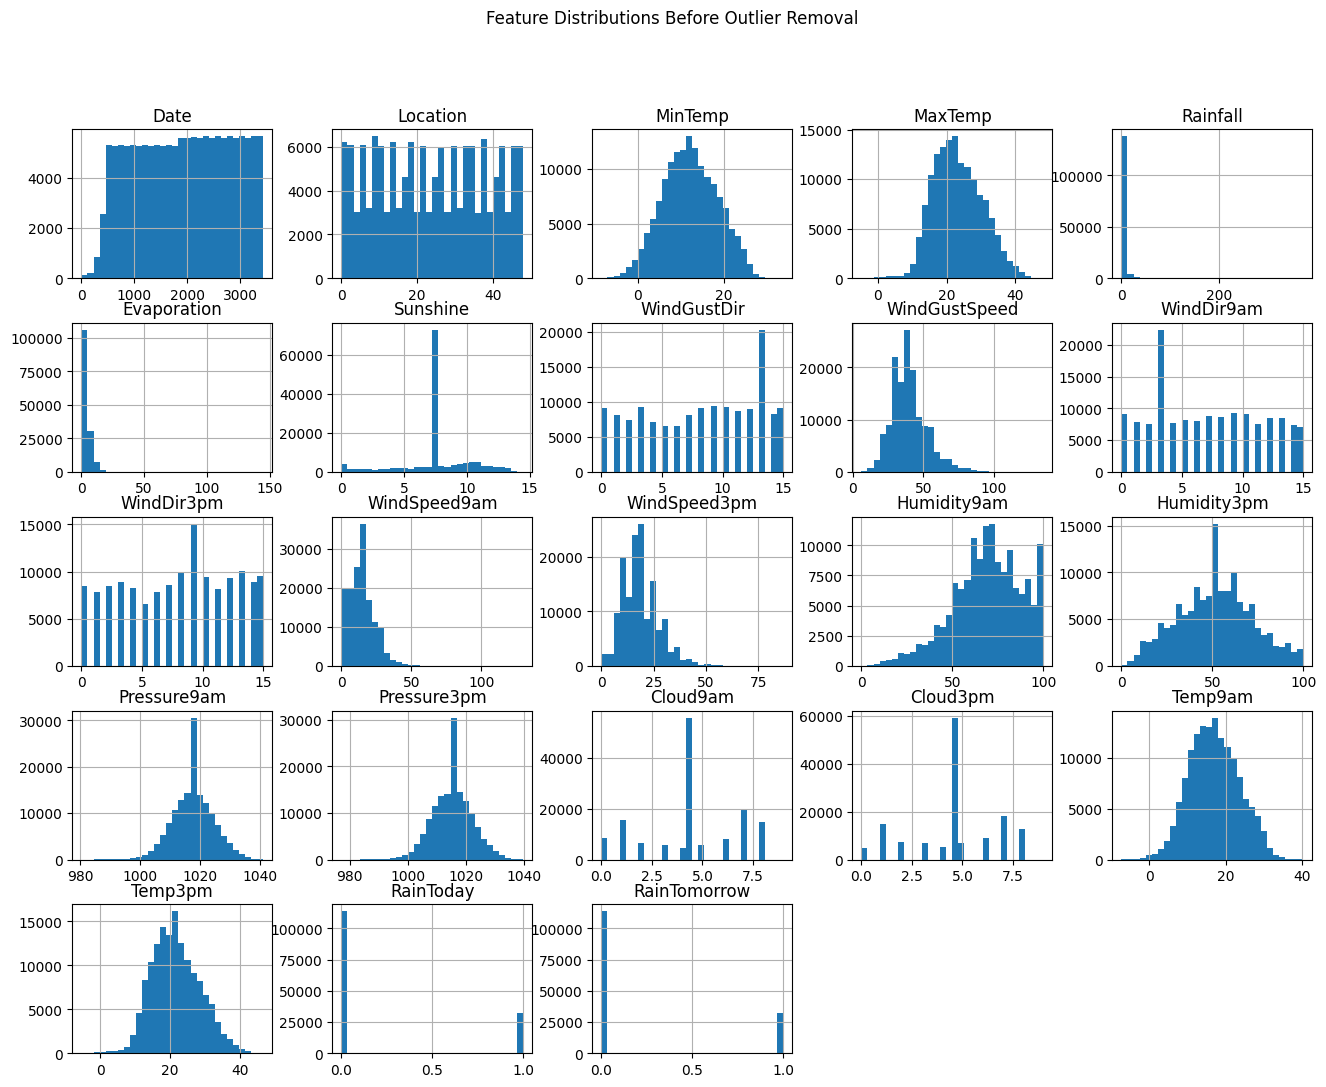

In [48]:
# Histograms Before Outlier Removal
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
df[numeric_cols].hist(figsize=(16, 12), bins=30)
plt.suptitle("Feature Distributions Before Outlier Removal")
plt.show()

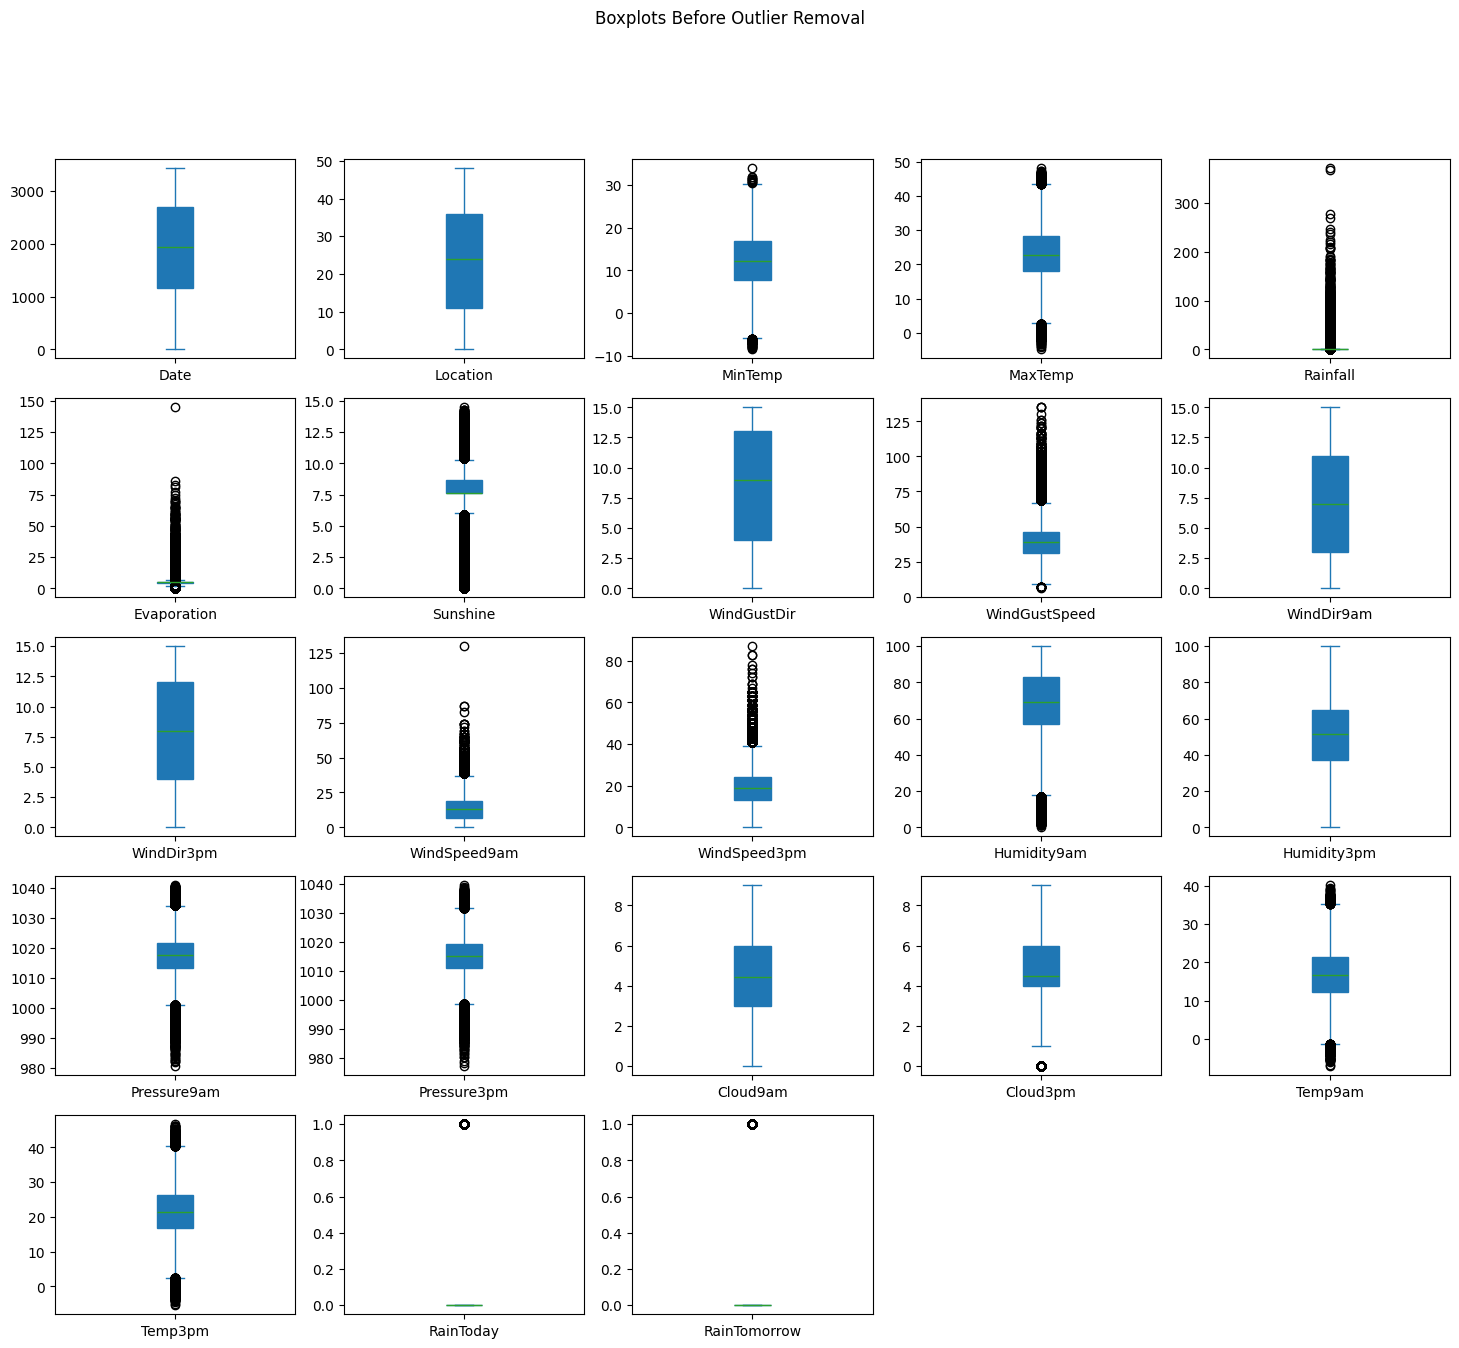

In [49]:
# Boxplots Before Outlier Removal
df[numeric_cols].plot(kind='box', subplots=True, layout=(5, 5), figsize=(18, 15), patch_artist=True)
plt.suptitle("Boxplots Before Outlier Removal")
plt.show()

In [50]:
# Remove Outliers Using IQR, but preserve class balance
def remove_outliers_safe(data, target_col):
    classes = data[target_col].unique()
    cleaned_parts = []
    for c in classes:
        subset = data[data[target_col] == c]
        Q1 = subset.quantile(0.25)
        Q3 = subset.quantile(0.75)
        IQR = Q3 - Q1
        cleaned_subset = subset[~((subset < (Q1 - 1.5 * IQR)) | (subset > (Q3 + 1.5 * IQR))).any(axis=1)]
        cleaned_parts.append(cleaned_subset)
    return pd.concat(cleaned_parts)

df_clean = remove_outliers_safe(df, "RainTomorrow")
print("Shape after outlier removal:", df_clean.shape)
print("Class distribution AFTER outlier removal:")
print(df_clean["RainTomorrow"].value_counts())


Shape after outlier removal: (77564, 23)
Class distribution AFTER outlier removal:
RainTomorrow
0    56485
1    21079
Name: count, dtype: int64


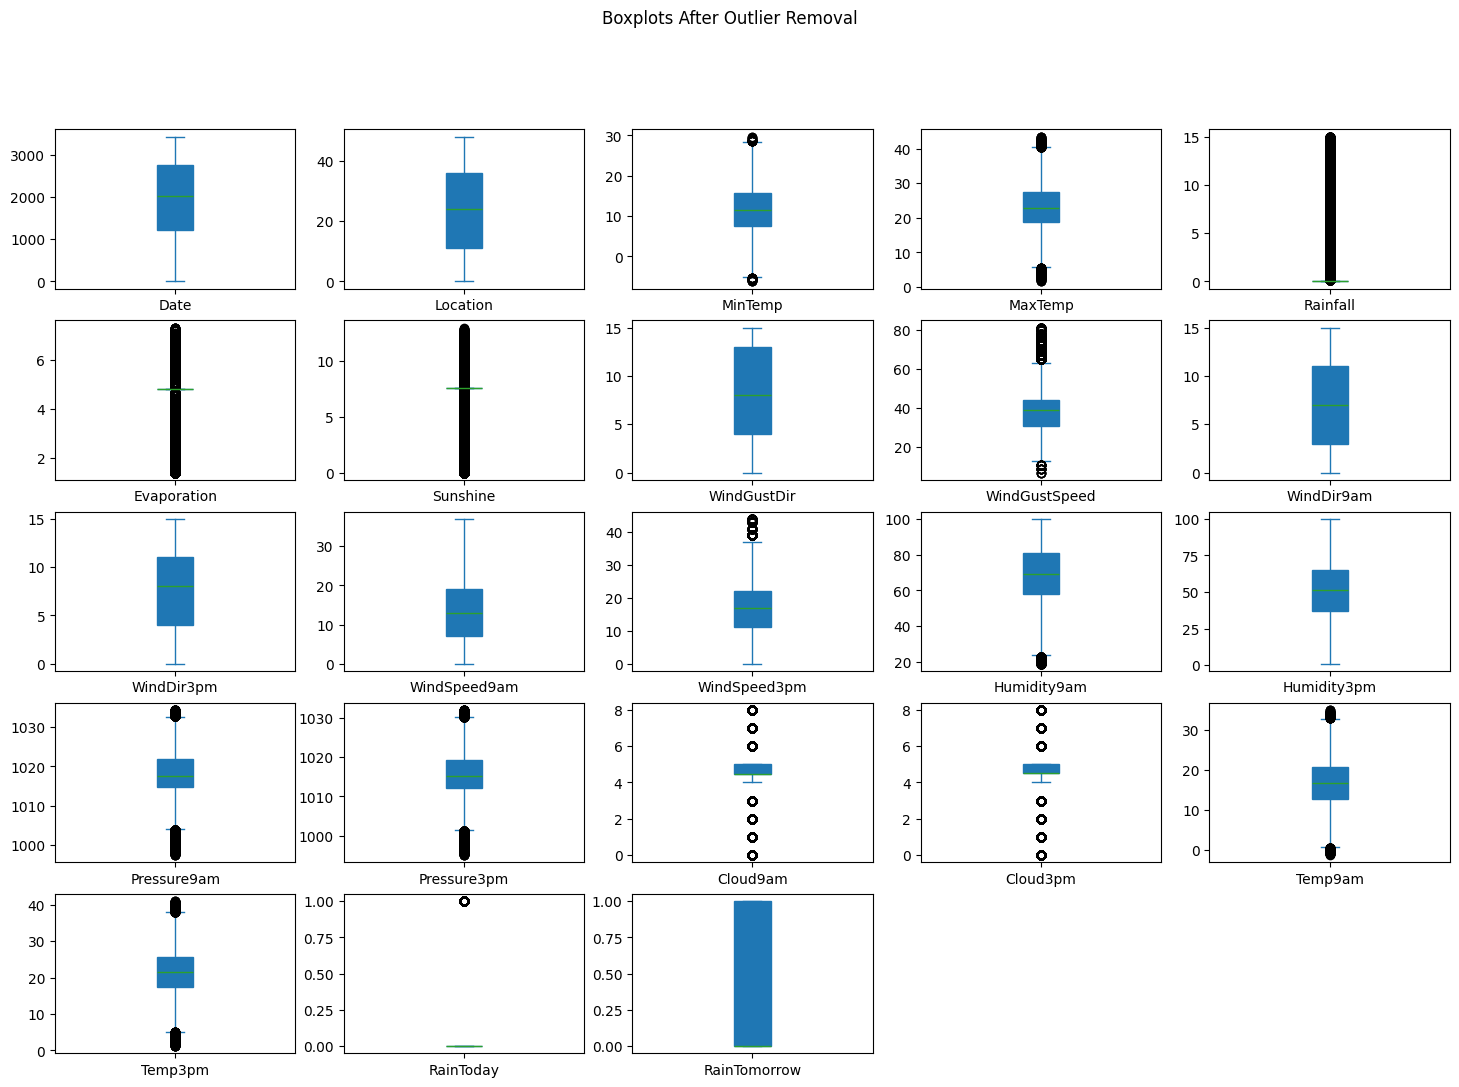

In [51]:
# Boxplots After Outlier Removal
df_clean[numeric_cols].plot(kind='box', subplots=True, layout=(5, 5), figsize=(18, 12), patch_artist=True)
plt.suptitle("Boxplots After Outlier Removal")
plt.show()

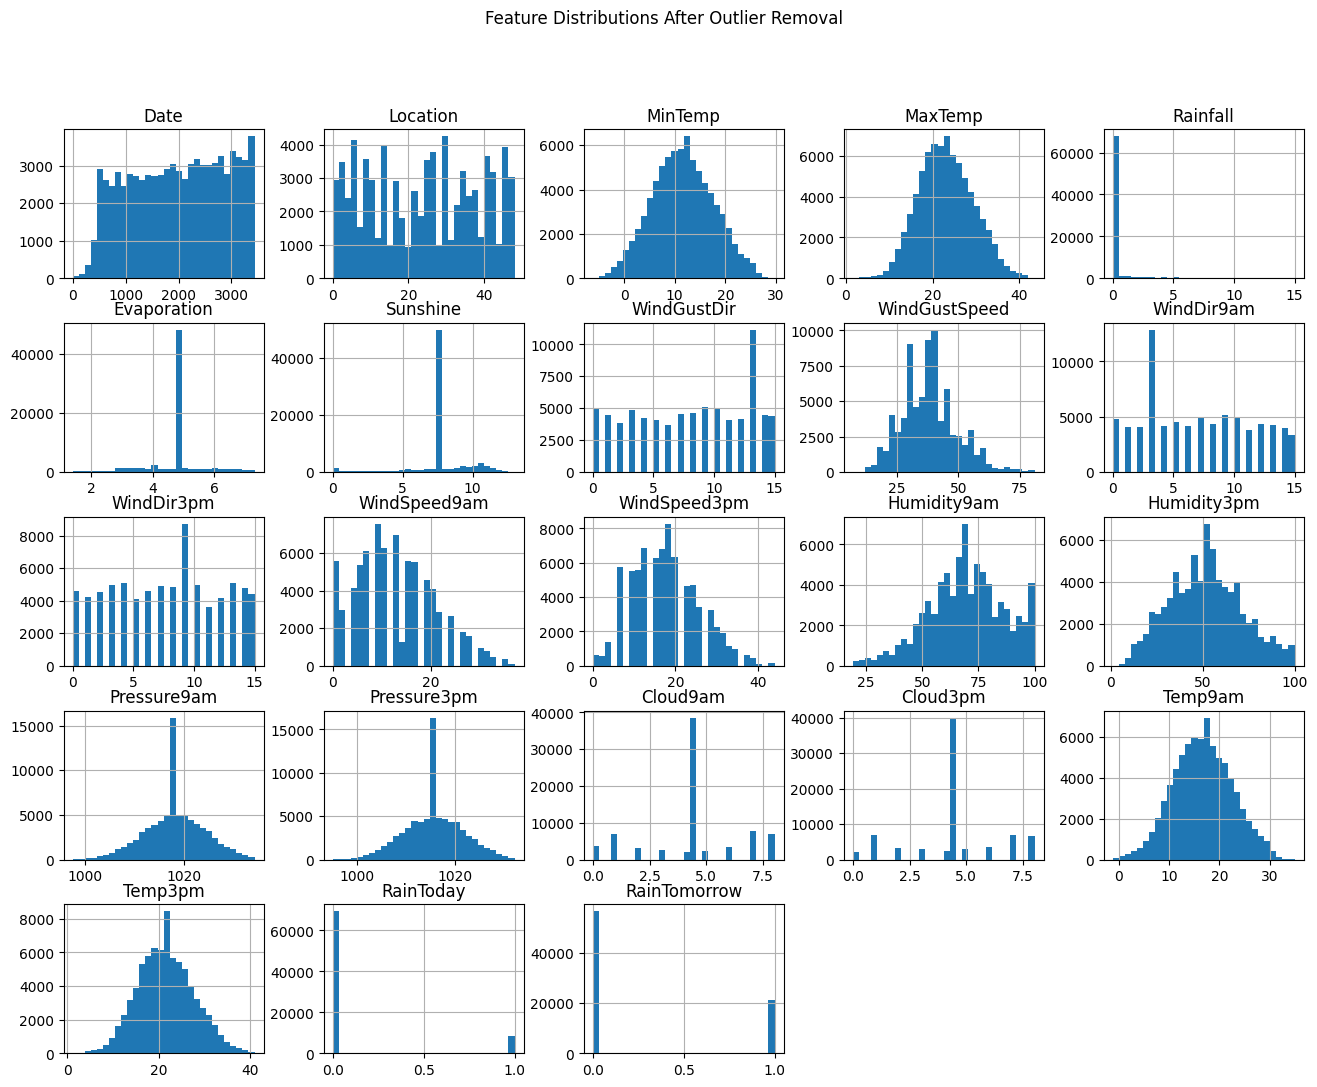

In [52]:
# Histograms After Outlier Removal
df_clean[numeric_cols].hist(figsize=(16, 12), bins=30)
plt.suptitle("Feature Distributions After Outlier Removal")
plt.show()

In [53]:
# Define Features and Target
X = df_clean.drop("RainTomorrow", axis=1)
y = df_clean["RainTomorrow"]

In [54]:
# Stratified Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [55]:
# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [56]:
# Train Logistic Regression
model = LogisticRegression(max_iter=1000)
model.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000)

In [57]:
# Evaluate Model
y_pred = model.predict(X_test_scaled)
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc * 100:.2f}%")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 89.55%

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.97      0.93     11297
           1       0.90      0.70      0.78      4216

    accuracy                           0.90     15513
   macro avg       0.90      0.83      0.86     15513
weighted avg       0.90      0.90      0.89     15513



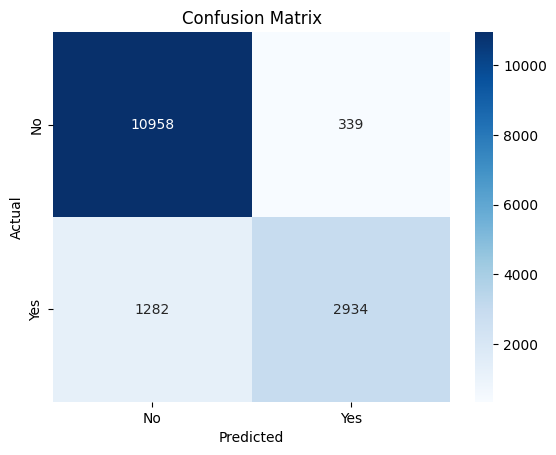

In [58]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=["No", "Yes"], yticklabels=["No", "Yes"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

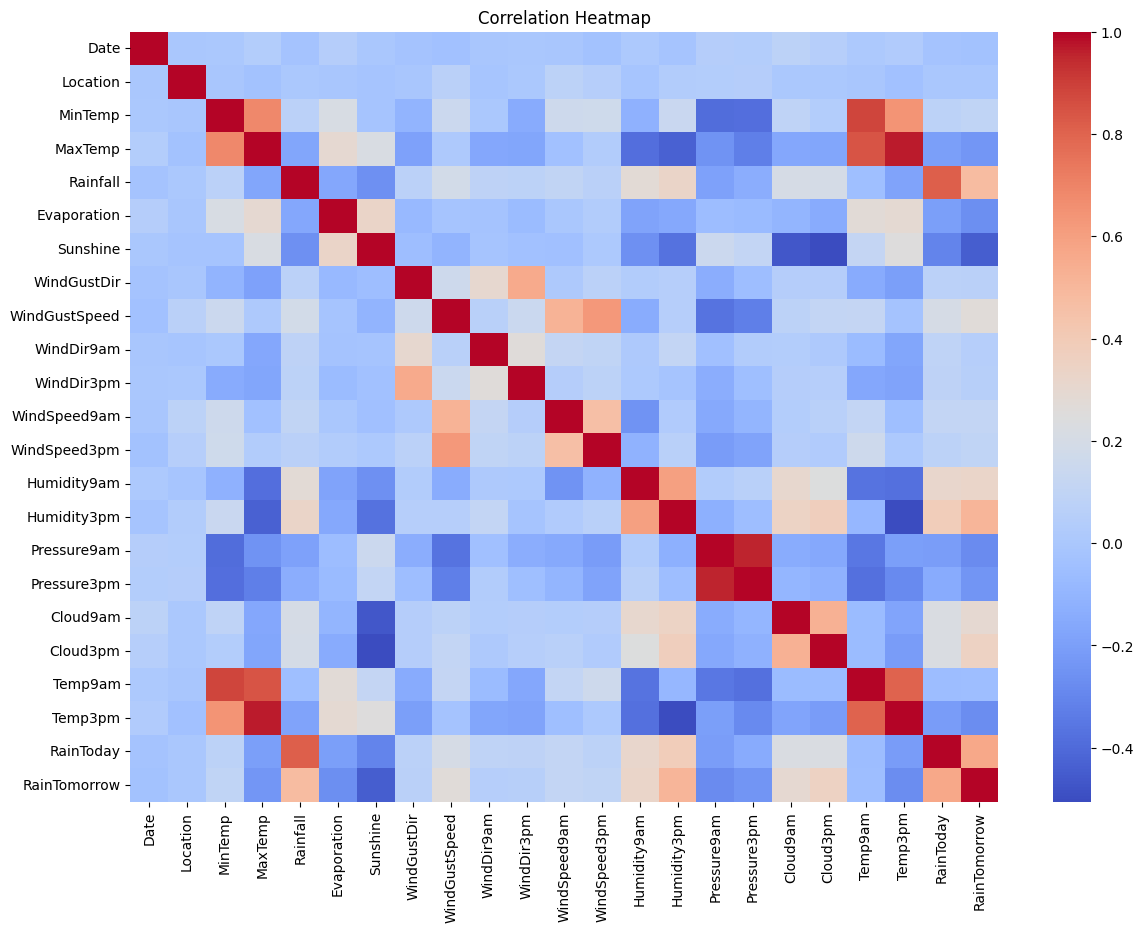

In [59]:
# Correlation Heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(df_clean.corr(), cmap='coolwarm', annot=False)
plt.title("Correlation Heatmap")
plt.show()